<a href="https://colab.research.google.com/github/PandaTGOS/Handwriting_Detection_System/blob/main/Number_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [ ]:
# Load the full MNIST dataset
full_trainset = datasets.MNIST('full_trainset', download=True, train=True, transform=transform)

# Split the full_trainset into trainset, valset, and testset
train_size = int(0.8 * len(full_trainset))
val_size = int(0.1 * len(full_trainset))
test_size = len(full_trainset) - (train_size + val_size)

trainset, valset, testset = torch.utils.data.random_split(full_trainset, [train_size, val_size, test_size])

# Create data loaders for trainset, valset, and testset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)  # No need to shuffle validation set
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 106742605.80it/s]


Extracting full_trainset/MNIST/raw/train-images-idx3-ubyte.gz to full_trainset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41742141.22it/s]


Extracting full_trainset/MNIST/raw/train-labels-idx1-ubyte.gz to full_trainset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32710694.98it/s]


Extracting full_trainset/MNIST/raw/t10k-images-idx3-ubyte.gz to full_trainset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19864993.50it/s]


Extracting full_trainset/MNIST/raw/t10k-labels-idx1-ubyte.gz to full_trainset/MNIST/raw



In [ ]:
dataiter = iter(trainloader)
images, labels  = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


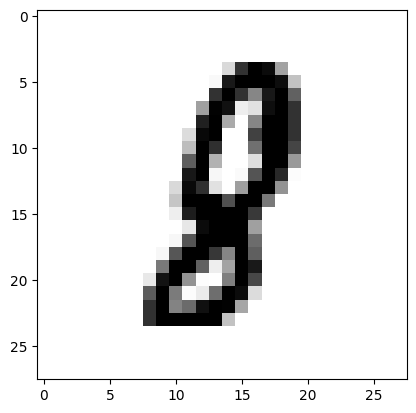

In [ ]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

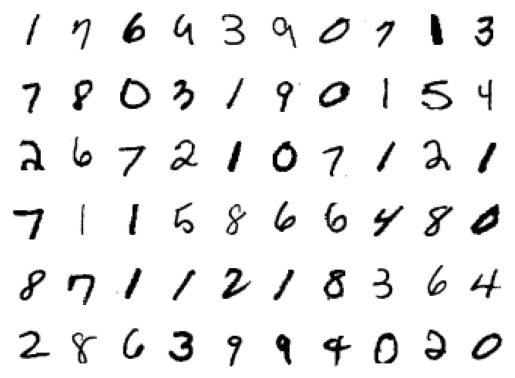

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [ ]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)
#Till here Un-trained Model

Before backward pass: 
 None
After backward pass: 
 tensor([[-2.6006e-03, -2.6006e-03, -2.6006e-03,  ..., -2.6006e-03,
         -2.6006e-03, -2.6006e-03],
        [-9.1606e-05, -9.1606e-05, -9.1606e-05,  ..., -9.1606e-05,
         -9.1606e-05, -9.1606e-05],
        [ 3.5110e-03,  3.5110e-03,  3.5110e-03,  ...,  3.5110e-03,
          3.5110e-03,  3.5110e-03],
        ...,
        [-5.1777e-03, -5.1777e-03, -5.1777e-03,  ..., -5.1777e-03,
         -5.1777e-03, -5.1777e-03],
        [ 1.6435e-03,  1.6435e-03,  1.6435e-03,  ...,  1.6435e-03,
          1.6435e-03,  1.6435e-03],
        [-3.8186e-03, -3.8186e-03, -3.8186e-03,  ..., -3.8186e-03,
         -3.8186e-03, -3.8186e-03]])


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

# Initialize lists to store metrics
losses = []
accuracies = []
val_losses = []
val_accuracies = []

time0 = time()
epochs = 40

for e in range(epochs):
    running_loss = 0
    correct_count = 0

    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy for this batch
        _, predicted = torch.max(output.data, 1)
        correct_count += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for this epoch
    avg_loss = running_loss / len(trainloader)
    accuracy = correct_count / len(trainloader.dataset)

    # Append loss and accuracy to lists
    losses.append(avg_loss)
    accuracies.append(accuracy)

    # Print epoch results for training
    print(f"Epoch {e+1}/{epochs} - Training loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode

    val_loss = 0
    val_correct_count = 0

    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(images.shape[0], -1)
            output = model(images)
            val_loss += criterion(output, labels).item()

            # Calculate accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            val_correct_count += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(valloader)
    val_accuracy = val_correct_count / len(valloader.dataset)

    # Append validation metrics to lists
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch results for validation
    print(f"Epoch {e+1}/{epochs} - Validation loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/40 - Training loss: 0.7155, Training Accuracy: 0.7939
Epoch 1/40 - Validation loss: 0.3589, Validation Accuracy: 0.8938
Epoch 2/40 - Training loss: 0.3030, Training Accuracy: 0.9098
Epoch 2/40 - Validation loss: 0.2938, Validation Accuracy: 0.9132
Epoch 3/40 - Training loss: 0.2472, Training Accuracy: 0.9264
Epoch 3/40 - Validation loss: 0.2494, Validation Accuracy: 0.9230
Epoch 4/40 - Training loss: 0.2054, Training Accuracy: 0.9400
Epoch 4/40 - Validation loss: 0.2135, Validation Accuracy: 0.9360
Epoch 5/40 - Training loss: 0.1759, Training Accuracy: 0.9478
Epoch 5/40 - Validation loss: 0.1869, Validation Accuracy: 0.9422
Epoch 6/40 - Training loss: 0.1526, Training Accuracy: 0.9552
Epoch 6/40 - Validation loss: 0.1809, Validation Accuracy: 0.9455
Epoch 7/40 - Training loss: 0.1338, Training Accuracy: 0.9603
Epoch 7/40 - Validation loss: 0.1663, Validation Accuracy: 0.9500
Epoch 8/40 - Training loss: 0.1201, Training Accuracy: 0.9643
Epoch 8/40 - Validation loss: 0.1519, Vali

In [ ]:
torch.save(model, './my_mnist_model.pt')

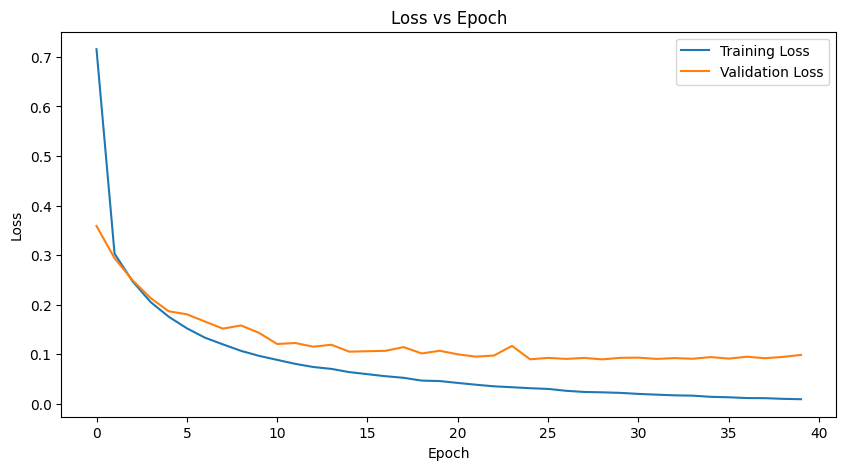

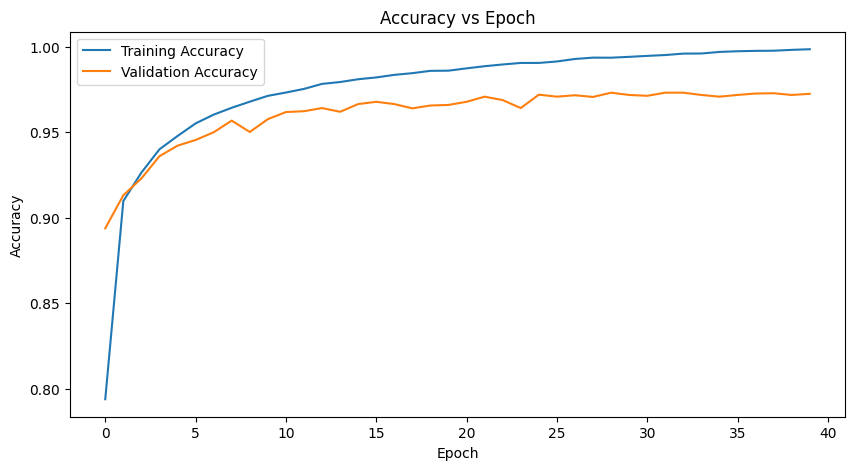

In [ ]:
# Plot loss vs epoch for both training and validation
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracy vs epoch for both training and validation
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [ ]:
model = torch.load('/content/my_mnist_model.pt')
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

Predicted Digit = 4


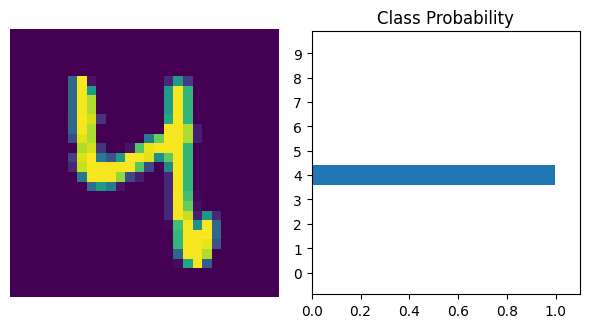

In [ ]:
images, labels = next(iter(valloader))

img = images[10].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [ ]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 6000

Model Accuracy = 0.9725


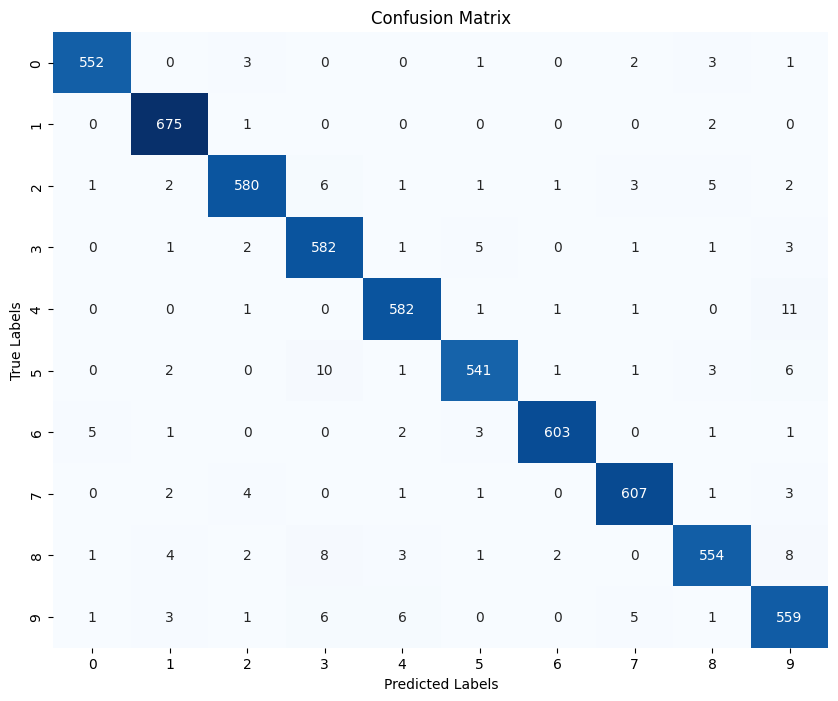

Class 0:
True Positives: 552,
True Negatives: 5430,
False Positives: 8,
False Negatives: 10

Class 1:
True Positives: 675,
True Negatives: 5307,
False Positives: 15,
False Negatives: 3

Class 2:
True Positives: 580,
True Negatives: 5384,
False Positives: 14,
False Negatives: 22

Class 3:
True Positives: 582,
True Negatives: 5374,
False Positives: 30,
False Negatives: 14

Class 4:
True Positives: 582,
True Negatives: 5388,
False Positives: 15,
False Negatives: 15

Class 5:
True Positives: 541,
True Negatives: 5422,
False Positives: 13,
False Negatives: 24

Class 6:
True Positives: 603,
True Negatives: 5379,
False Positives: 5,
False Negatives: 13

Class 7:
True Positives: 607,
True Negatives: 5368,
False Positives: 13,
False Negatives: 12

Class 8:
True Positives: 554,
True Negatives: 5400,
False Positives: 17,
False Negatives: 29

Class 9:
True Positives: 559,
True Negatives: 5383,
False Positives: 35,
False Negatives: 23



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set the model to evaluation mode
model.eval()

# Lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the validation data loader
for images, labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)

        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]

        true_labels.append(true_label)
        pred_labels.append(pred_label)

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print true positives, true negatives, false positives, false negatives for each class
for i in range(10):  # Assuming 10 classes
    tp = conf_matrix[i, i]
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    fp = np.sum(conf_matrix[:, i]) - tp
    fn = np.sum(conf_matrix[i, :]) - tp
    print(f"Class {i}:")
    print(f"True Positives: {tp},\nTrue Negatives: {tn},\nFalse Positives: {fp},\nFalse Negatives: {fn}")
    print()

In [ ]:
# Print the classification report
target_names = [str(i) for i in range(10)]
print(classification_report(true_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       562
           1       0.98      1.00      0.99       678
           2       0.98      0.96      0.97       602
           3       0.95      0.98      0.96       596
           4       0.97      0.97      0.97       597
           5       0.98      0.96      0.97       565
           6       0.99      0.98      0.99       616
           7       0.98      0.98      0.98       619
           8       0.97      0.95      0.96       583
           9       0.94      0.96      0.95       582

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



Predicted Digit = 4
Predicted Digit = 3
Predicted Digit = 3


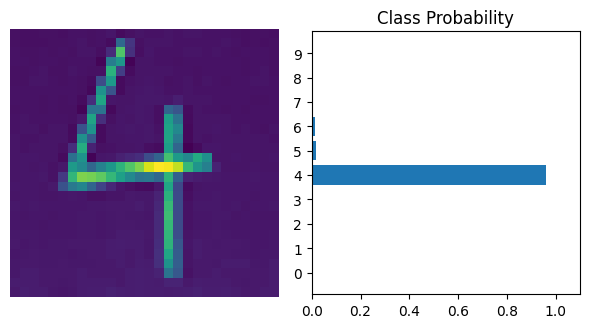

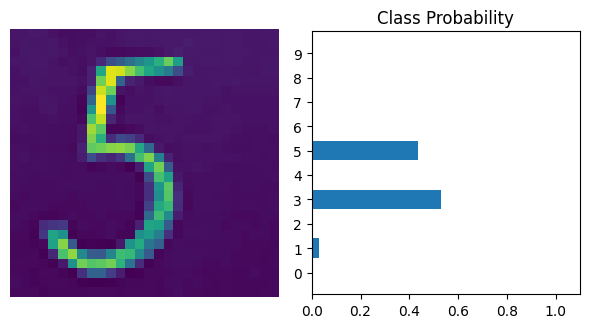

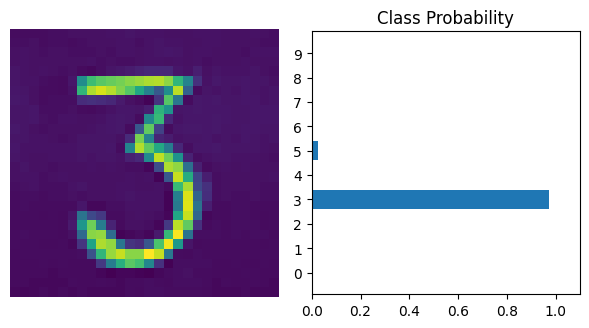

In [ ]:
#if the image has a handwritten digit over a white background, use this, else comment the whole cell out
from PIL import Image, ImageOps
import os

def preprocess_user_image(image_path):
    user_image = Image.open(image_path).convert("L")
    user_image = ImageOps.invert(user_image)  # Add this line to invert colors
    user_image = user_image.resize((28, 28))
    user_image = transform(user_image).view(1, 784)
    return user_image

# Get the path to the user's image

for image in os.listdir('/content/BOW_Digits'):
    user_image_path = os.path.join("/content/BOW_Digits", image)
    if os.path.isfile(user_image_path):
        # Preprocess the user's image
        user_input = preprocess_user_image(user_image_path)

        # Use the trained model to make a prediction
        with torch.no_grad():
            logps = model(user_input)
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])

        predicted_digit = probab.index(max(probab))
        print("Predicted Digit =", predicted_digit)
        view_classify(user_input.view(1, 28, 28), ps)
#     view_classify(user_input.view(1, 28, 28), ps)

Predicted Digit = 2
Predicted Digit = 0
Predicted Digit = 1


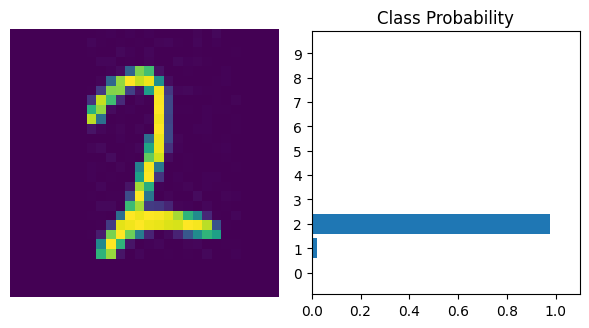

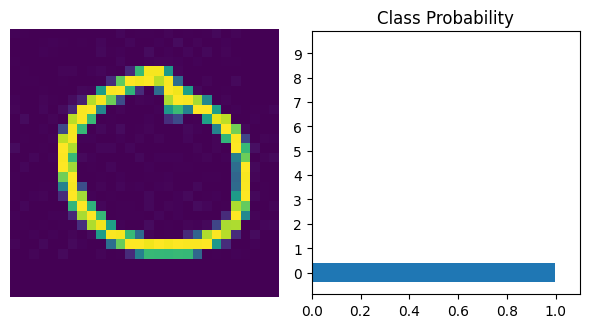

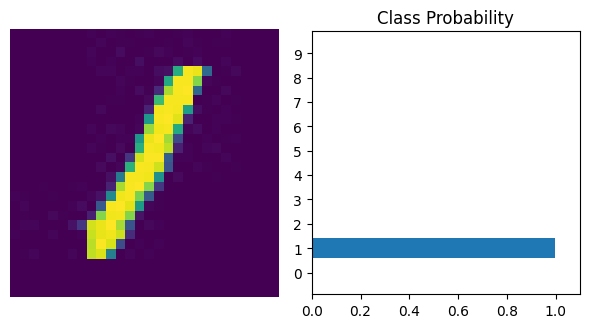

In [ ]:
import os

def preprocess_user_image(image_path):
    user_image = Image.open(image_path).convert("L")
    user_image = user_image.resize((28, 28))
    user_image = transform(user_image).view(1, 784)
    return user_image

# Get the path to the user's image

for image in os.listdir('/content/WOB_Digits'):
    user_image_path = os.path.join("/content/WOB_Digits", image)
    if os.path.isfile(user_image_path):
        # Preprocess the user's image
        user_input = preprocess_user_image(user_image_path)

        # Use the trained model to make a prediction
        with torch.no_grad():
            logps = model(user_input)
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])

        predicted_digit = probab.index(max(probab))
        print("Predicted Digit =", predicted_digit)
        view_classify(user_input.view(1, 28, 28), ps)
#     view_classify(user_input.view(1, 28, 28), ps)

